# Data Preprocessing for SOC Estimation
## Stanford TECH 27 Final Project - Notebook 2

This notebook preprocesses the NASA Battery Dataset for State of Charge (SOC) estimation models.

### Goals:
1. Load and filter battery data files
2. Calculate SOC labels from discharge data
3. Engineer features for conventional ML models
4. Prepare sequential data for deep learning models
5. Create train/validation/test splits
6. Scale and standardize features

### Output:
- Preprocessed datasets ready for modeling
- Feature engineering pipeline
- Data splits with proper SOC labels

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import pickle
import warnings
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import gc

warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

print("Libraries imported successfully!")
print(f"NumPy version: {np.__version__}")
print(f"Pandas version: {pd.__version__}")

Libraries imported successfully!
NumPy version: 2.3.2
Pandas version: 2.3.2


## 1. Data Loading and Filtering Functions

In [2]:
# Dataset paths
data_dir = Path('dataset/data')
metadata_file = Path('dataset/metadata.csv')
output_dir = Path('processed_data')
output_dir.mkdir(exist_ok=True)

# Load metadata
metadata = pd.read_csv(metadata_file)
print(f"Loaded metadata with {len(metadata)} entries")

# Convert capacity to numeric
metadata['Capacity'] = pd.to_numeric(metadata['Capacity'], errors='coerce')
print(f"Valid capacity entries: {metadata['Capacity'].notna().sum()}")

Loaded metadata with 7565 entries
Valid capacity entries: 2769


In [3]:
def load_battery_file(file_path):
    """
    Load a battery data file with error handling
    Returns None if file cannot be loaded or doesn't have expected columns
    """
    try:
        data = pd.read_csv(file_path)
        
        # Check for expected columns
        required_columns = ['Voltage_measured', 'Current_measured', 'Temperature_measured', 'Time']
        if not all(col in data.columns for col in required_columns):
            return None
        
        # Basic data validation
        if len(data) < 10:  # Skip very short files
            return None
            
        # Sort by time to ensure proper ordering
        data = data.sort_values('Time').reset_index(drop=True)
        
        return data
        
    except Exception as e:
        return None

def filter_discharge_files(metadata, min_duration_hours=0.5, max_duration_hours=10):
    """
    Filter discharge files based on duration and data quality
    """
    discharge_meta = metadata[metadata['type'] == 'discharge'].copy()
    valid_files = []
    
    print(f"Processing {len(discharge_meta)} discharge files...")
    
    for idx, row in tqdm(discharge_meta.iterrows(), total=len(discharge_meta)):
        file_path = data_dir / row['filename']
        data = load_battery_file(file_path)
        
        if data is not None:
            # Check duration
            duration_hours = (data['Time'].max() - data['Time'].min()) / 3600
            
            # Check if it's actually a discharge (current should be mostly negative)
            avg_current = data['Current_measured'].mean()
            
            if (min_duration_hours <= duration_hours <= max_duration_hours and 
                avg_current < -0.1):  # Discharge current threshold
                valid_files.append({
                    'filename': row['filename'],
                    'battery_id': row['battery_id'],
                    'test_id': row['test_id'],
                    'capacity': row['Capacity'] if pd.notna(row['Capacity']) else None,
                    'duration_hours': duration_hours,
                    'data_points': len(data),
                    'avg_current': avg_current
                })
    
    valid_df = pd.DataFrame(valid_files)
    print(f"Found {len(valid_df)} valid discharge files")
    
    return valid_df

# Filter valid discharge files
valid_discharge_files = filter_discharge_files(metadata)
print(f"\nValid discharge files by battery:")
print(valid_discharge_files.groupby('battery_id').size().sort_values(ascending=False))

Processing 2794 discharge files...


100%|██████████| 2794/2794 [00:01<00:00, 1702.30it/s]

Found 2360 valid discharge files

Valid discharge files by battery:
battery_id
B0034    197
B0036    197
B0033    197
B0005    168
B0007    168
B0006    168
B0018    132
B0055    102
B0054    102
B0056    102
B0047     72
B0048     72
B0046     72
B0045     72
B0043     66
B0044     66
B0042     66
B0053     55
B0040     33
B0038     33
B0039     33
B0027     28
B0026     28
B0025     28
B0028     28
B0041     25
B0049     16
B0051     16
B0050     15
B0052      3
dtype: int64


## 2. SOC Calculation and Labeling Pipeline

Testing SOC calculation on first 3 files:

--- Testing file 1: 00001.csv ---
Rejecting 00001.csv due to poor SOC data quality
Failed to process or rejected due to poor quality

--- Testing file 2: 00005.csv ---
Rejecting 00005.csv due to poor SOC data quality
Failed to process or rejected due to poor quality

--- Testing file 3: 00007.csv ---
Rejecting 00007.csv due to poor SOC data quality
Failed to process or rejected due to poor quality
Rejecting 00001.csv due to poor SOC data quality
Rejecting 00005.csv due to poor SOC data quality
Rejecting 00007.csv due to poor SOC data quality
Rejecting 00009.csv due to poor SOC data quality
Rejecting 00011.csv due to poor SOC data quality
Rejecting 00013.csv due to poor SOC data quality
Rejecting 00017.csv due to poor SOC data quality
Rejecting 00021.csv due to poor SOC data quality
Rejecting 00023.csv due to poor SOC data quality
Rejecting 00025.csv due to poor SOC data quality
Rejecting 00027.csv due to poor SOC data quality
Rejecting 00029.c

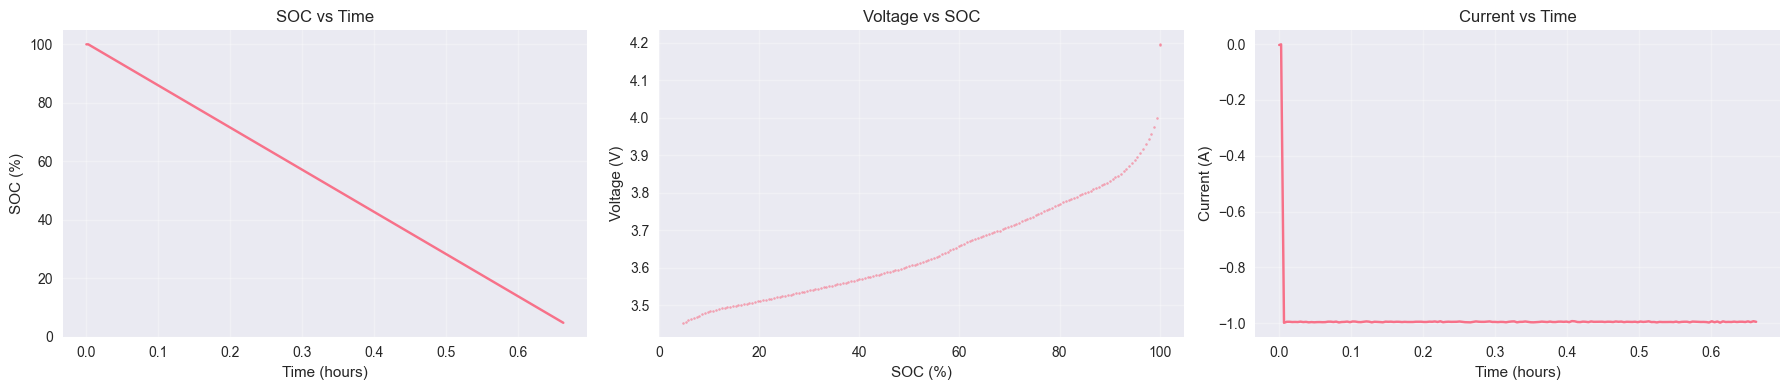

In [4]:
def calculate_soc_from_discharge(data, initial_capacity=None):
    """
    Calculate State of Charge from discharge data using current integration
    SOC = (Initial_Capacity - Discharged_Capacity) / Initial_Capacity
    """
    # Calculate time intervals (in hours)
    time_diff = np.diff(data['Time'], prepend=0) / 3600
    
    # Calculate discharged capacity (Ah) using current integration
    # Make discharge current positive for integration
    current = -data['Current_measured'].values
    discharged_capacity = np.cumsum(current * time_diff)
    
    # Handle initial capacity
    if initial_capacity is not None:
        try:
            initial_capacity = float(initial_capacity)
            if initial_capacity <= 0:
                initial_capacity = None
        except (ValueError, TypeError):
            initial_capacity = None
    
    # Estimate initial capacity if not provided
    if initial_capacity is None:
        # Use final discharged capacity + 5% margin
        initial_capacity = discharged_capacity[-1] * 1.05
    
    # Calculate SOC
    soc = (initial_capacity - discharged_capacity) / initial_capacity
    
    # Don't clip SOC here - let validation function handle data quality
    
    return soc, discharged_capacity, initial_capacity

def validate_soc_data(data, min_soc=0.0, max_soc=1.2, voltage_soc_correlation_threshold=-0.5):
    """
    Validate SOC data quality and filter out bad discharge cycles
    
    Parameters:
    - min_soc: Minimum reasonable SOC value (allow some negative for over-discharge)
    - max_soc: Maximum reasonable SOC value (allow >1 for capacity estimation errors)
    - voltage_soc_correlation_threshold: Minimum correlation between voltage and SOC
    """
    # Check SOC range
    if data['SOC'].min() < min_soc or data['SOC'].max() > max_soc:
        print(f"Warning: SOC out of reasonable range [{min_soc}, {max_soc}]: {data['SOC'].min():.3f} - {data['SOC'].max():.3f}")
        return False
    
    # Check voltage-SOC correlation (should be positive for discharge)
    correlation = data['Voltage_measured'].corr(data['SOC'])
    if correlation < voltage_soc_correlation_threshold:
        print(f"Warning: Poor voltage-SOC correlation: {correlation:.3f} (expected > {voltage_soc_correlation_threshold})")
        return False
    
    # Check for monotonic discharge behavior
    soc_trend = data['SOC'].diff().mean()
    if soc_trend > -0.001:  # SOC should generally decrease during discharge
        print(f"Warning: SOC not decreasing during discharge: trend = {soc_trend:.6f}")
        return False
    
    return True

def process_discharge_file_with_soc(filename, battery_id, capacity=None):
    """
    Process a single discharge file and add SOC labels with validation
    """
    file_path = data_dir / filename
    data = load_battery_file(file_path)
    
    if data is None:
        return None
    
    # Calculate SOC
    soc, discharged_capacity, initial_capacity = calculate_soc_from_discharge(data, capacity)
    
    # Add SOC and metadata to dataframe
    data['SOC'] = soc
    data['discharged_capacity'] = discharged_capacity
    data['battery_id'] = battery_id
    data['filename'] = filename
    data['initial_capacity'] = initial_capacity
    
    # Validate SOC data quality
    if not validate_soc_data(data):
        print(f"Rejecting {filename} due to poor SOC data quality")
        return None
    
    # Apply reasonable clipping after validation passes
    data['SOC'] = np.clip(data['SOC'], 0.0, 1.0)
    
    return data

# Test SOC calculation on multiple sample files to check for quality issues
if len(valid_discharge_files) > 0:
    print("Testing SOC calculation on first 3 files:")
    
    for i in range(min(3, len(valid_discharge_files))):
        sample_file = valid_discharge_files.iloc[i]
        print(f"\n--- Testing file {i+1}: {sample_file['filename']} ---")
        
        sample_data = process_discharge_file_with_soc(
            sample_file['filename'], 
            sample_file['battery_id'], 
            sample_file['capacity']
        )
        
        if sample_data is not None:
            print(f"SOC range: {sample_data['SOC'].min():.4f} - {sample_data['SOC'].max():.4f}")
            print(f"Voltage range: {sample_data['Voltage_measured'].min():.3f} - {sample_data['Voltage_measured'].max():.3f} V")
            print(f"Voltage-SOC correlation: {sample_data['Voltage_measured'].corr(sample_data['SOC']):.3f}")
            print(f"Data points: {len(sample_data)}")
            print(f"Initial capacity used: {sample_data['initial_capacity'].iloc[0]:.4f} Ah")
        else:
            print("Failed to process or rejected due to poor quality")
    
    # Use the first valid file for visualization
    sample_data = None
    for i in range(len(valid_discharge_files)):
        test_data = process_discharge_file_with_soc(
            valid_discharge_files.iloc[i]['filename'], 
            valid_discharge_files.iloc[i]['battery_id'], 
            valid_discharge_files.iloc[i]['capacity']
        )
        if test_data is not None:
            sample_data = test_data
            break
    
    if sample_data is not None:
        # Quick visualization
        fig, axes = plt.subplots(1, 3, figsize=(18, 4))
        
        # SOC vs Time
        axes[0].plot(sample_data['Time'] / 3600, sample_data['SOC'] * 100)
        axes[0].set_title('SOC vs Time')
        axes[0].set_xlabel('Time (hours)')
        axes[0].set_ylabel('SOC (%)')
        axes[0].grid(alpha=0.3)
        
        # Voltage vs SOC
        axes[1].scatter(sample_data['SOC'] * 100, sample_data['Voltage_measured'], alpha=0.6, s=2)
        axes[1].set_title('Voltage vs SOC')
        axes[1].set_xlabel('SOC (%)')
        axes[1].set_ylabel('Voltage (V)')
        axes[1].grid(alpha=0.3)
        
        # Current vs Time
        axes[2].plot(sample_data['Time'] / 3600, sample_data['Current_measured'])
        axes[2].set_title('Current vs Time')
        axes[2].set_xlabel('Time (hours)')
        axes[2].set_ylabel('Current (A)')
        axes[2].grid(alpha=0.3)
        
        plt.tight_layout()
        plt.show()
    else:
        print("No valid sample files found for visualization")
else:
    print("No valid discharge files found")

## 3. Feature Engineering for Conventional ML Models

In [5]:
def engineer_features(data, window_size=10):
    """
    Engineer features for conventional ML models
    Returns DataFrame with engineered features and SOC target
    """
    features = pd.DataFrame()
    
    # Basic measurements
    features['voltage'] = data['Voltage_measured']
    features['current'] = data['Current_measured']
    features['temperature'] = data['Temperature_measured']
    features['time'] = data['Time']
    
    # Derived features
    features['power'] = features['voltage'] * features['current']
    features['abs_current'] = np.abs(features['current'])
    features['voltage_current_ratio'] = features['voltage'] / (features['abs_current'] + 1e-6)
    
    # Rate of change features
    features['voltage_change'] = features['voltage'].diff()
    features['current_change'] = features['current'].diff()
    features['temperature_change'] = features['temperature'].diff()
    features['power_change'] = features['power'].diff()
    
    # Rolling statistics (short window)
    for col in ['voltage', 'current', 'temperature', 'power']:
        features[f'{col}_rolling_mean_{window_size}'] = features[col].rolling(window=window_size, min_periods=1).mean()
        features[f'{col}_rolling_std_{window_size}'] = features[col].rolling(window=window_size, min_periods=1).std()
        features[f'{col}_rolling_min_{window_size}'] = features[col].rolling(window=window_size, min_periods=1).min()
        features[f'{col}_rolling_max_{window_size}'] = features[col].rolling(window=window_size, min_periods=1).max()
    
    # Rolling statistics (longer window)
    long_window = window_size * 3
    for col in ['voltage', 'current']:
        features[f'{col}_rolling_mean_{long_window}'] = features[col].rolling(window=long_window, min_periods=1).mean()
        features[f'{col}_rolling_std_{long_window}'] = features[col].rolling(window=long_window, min_periods=1).std()
    
    # Cumulative features
    time_diff = features['time'].diff().fillna(0) / 3600  # Convert to hours
    features['cumulative_discharge'] = (features['abs_current'] * time_diff).cumsum()
    features['cumulative_energy'] = (features['power'].abs() * time_diff).cumsum()
    
    # Time-based features
    features['time_since_start'] = features['time'] - features['time'].iloc[0]
    features['time_normalized'] = features['time_since_start'] / (features['time_since_start'].iloc[-1] + 1e-6)
    
    # Lag features
    for lag in [1, 5, 10]:
        features[f'voltage_lag_{lag}'] = features['voltage'].shift(lag)
        features[f'current_lag_{lag}'] = features['current'].shift(lag)
    
    # Statistical features over entire discharge
    features['voltage_vs_mean'] = features['voltage'] - features['voltage'].mean()
    features['current_vs_mean'] = features['current'] - features['current'].mean()
    features['voltage_percentile'] = features['voltage'].rank(pct=True)
    
    # Target variable
    features['SOC'] = data['SOC']
    
    # Add metadata
    features['battery_id'] = data['battery_id']
    features['filename'] = data['filename']
    
    # Fill NaN values
    features = features.fillna(method='bfill').fillna(method='ffill').fillna(0)
    
    return features

# Test feature engineering on sample data
if sample_data is not None:
    sample_features = engineer_features(sample_data)
    
    print(f"Engineered features shape: {sample_features.shape}")
    print(f"Number of features: {len([col for col in sample_features.columns if col not in ['SOC', 'battery_id', 'filename']])}")
    
    print("\nFeature columns:")
    feature_cols = [col for col in sample_features.columns if col not in ['SOC', 'battery_id', 'filename']]
    for i, col in enumerate(feature_cols[:20]):  # Show first 20
        print(f"  {i+1:2d}. {col}")
    if len(feature_cols) > 20:
        print(f"  ... and {len(feature_cols) - 20} more features")
    
    print(f"\nFeature statistics (first 10 features):")
    print(sample_features[feature_cols[:10]].describe().round(4))

Engineered features shape: (175, 47)
Number of features: 44

Feature columns:
   1. voltage
   2. current
   3. temperature
   4. time
   5. power
   6. abs_current
   7. voltage_current_ratio
   8. voltage_change
   9. current_change
  10. temperature_change
  11. power_change
  12. voltage_rolling_mean_10
  13. voltage_rolling_std_10
  14. voltage_rolling_min_10
  15. voltage_rolling_max_10
  16. current_rolling_mean_10
  17. current_rolling_std_10
  18. current_rolling_min_10
  19. current_rolling_max_10
  20. temperature_rolling_mean_10
  ... and 24 more features

Feature statistics (first 10 features):
        voltage   current  temperature       time     power  abs_current  \
count  175.0000  175.0000     175.0000   175.0000  175.0000     175.0000   
mean     3.6507   -0.9840       7.1929  1189.2689   -3.5860       0.9840   
std      0.1435    0.1059       0.8694   694.5502    0.4074       0.1059   
min      3.4526   -0.9986       4.8838     0.0000   -3.9937       0.0007   
25%  

## 4. Sequential Data Preparation for Deep Learning

LSTM sequences shape: X=(145, 30, 10), y=(145,)
Features used: ['voltage', 'current', 'temperature', 'power', 'voltage_change', 'current_change', 'temperature_change', 'cumulative_discharge', 'cumulative_energy', 'time_normalized']
CNN sequences shape: X=(13, 50, 10), y=(13,)


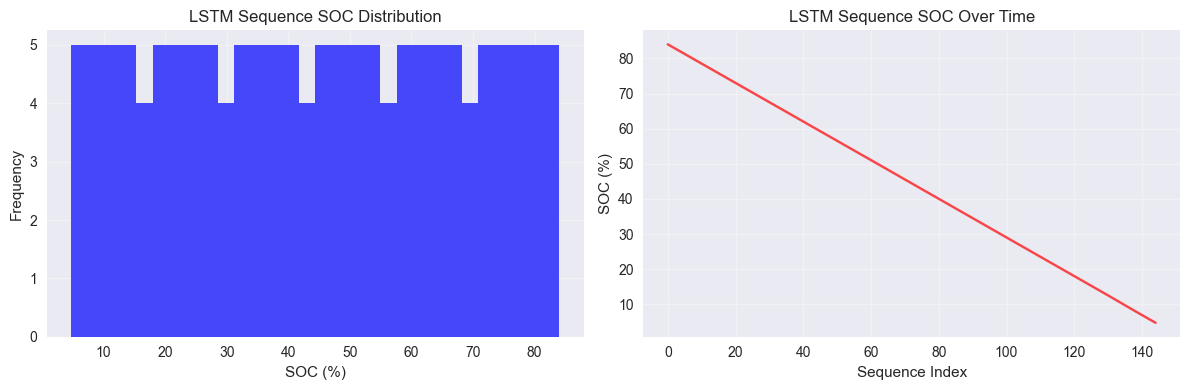

In [6]:
def prepare_sequences(data, sequence_length=50, step=1):
    """
    Prepare sequential data for RNN/LSTM/GRU models
    
    Parameters:
    - sequence_length: Number of time steps in each sequence
    - step: Step size for creating sequences (1 = overlapping)
    
    Returns:
    - X_sequences: Input sequences (samples, time_steps, features)
    - y_sequences: Target SOC values
    """
    # Select features for sequences (exclude metadata)
    feature_cols = ['voltage', 'current', 'temperature', 'power',
                   'voltage_change', 'current_change', 'temperature_change',
                   'cumulative_discharge', 'cumulative_energy',
                   'time_normalized']
    
    # Ensure all feature columns exist
    available_cols = [col for col in feature_cols if col in data.columns]
    
    X = data[available_cols].values
    y = data['SOC'].values
    
    X_sequences = []
    y_sequences = []
    
    for i in range(sequence_length, len(X), step):
        X_sequences.append(X[i-sequence_length:i])
        y_sequences.append(y[i])  # Predict SOC at current time step
    
    return np.array(X_sequences), np.array(y_sequences), available_cols

def prepare_cnn_sequences(data, sequence_length=100, step=10):
    """
    Prepare sequential data for 1D CNN models
    Longer sequences with larger steps for CNN
    """
    return prepare_sequences(data, sequence_length, step)

# Test sequence preparation
if sample_data is not None:
    # Prepare sequences for LSTM/RNN
    X_lstm, y_lstm, feature_names = prepare_sequences(sample_features, sequence_length=30)
    print(f"LSTM sequences shape: X={X_lstm.shape}, y={y_lstm.shape}")
    print(f"Features used: {feature_names}")
    
    # Prepare sequences for CNN
    X_cnn, y_cnn, _ = prepare_cnn_sequences(sample_features, sequence_length=50)
    print(f"CNN sequences shape: X={X_cnn.shape}, y={y_cnn.shape}")
    
    # Visualize sequence SOC distribution
    plt.figure(figsize=(12, 4))
    
    plt.subplot(1, 2, 1)
    plt.hist(y_lstm * 100, bins=30, alpha=0.7, color='blue')
    plt.title('LSTM Sequence SOC Distribution')
    plt.xlabel('SOC (%)')
    plt.ylabel('Frequency')
    plt.grid(alpha=0.3)
    
    plt.subplot(1, 2, 2)
    plt.plot(y_lstm * 100, alpha=0.7, color='red')
    plt.title('LSTM Sequence SOC Over Time')
    plt.xlabel('Sequence Index')
    plt.ylabel('SOC (%)')
    plt.grid(alpha=0.3)
    
    plt.tight_layout()
    plt.show()

## 5. Batch Processing All Valid Discharge Files

Processing first 20 files for testing...
Processing 20 discharge files...


100%|██████████| 20/20 [00:00<00:00, 830.42it/s]

Rejecting 00001.csv due to poor SOC data quality
Rejecting 00005.csv due to poor SOC data quality
Rejecting 00007.csv due to poor SOC data quality
Rejecting 00009.csv due to poor SOC data quality
Rejecting 00011.csv due to poor SOC data quality
Rejecting 00013.csv due to poor SOC data quality
Rejecting 00017.csv due to poor SOC data quality
Rejecting 00021.csv due to poor SOC data quality
Rejecting 00023.csv due to poor SOC data quality
Rejecting 00025.csv due to poor SOC data quality
Rejecting 00027.csv due to poor SOC data quality
Rejecting 00029.csv due to poor SOC data quality
Rejecting 00033.csv due to poor SOC data quality
Rejecting 00037.csv due to poor SOC data quality
Rejecting 00039.csv due to poor SOC data quality
Rejecting 00041.csv due to poor SOC data quality
Rejecting 00043.csv due to poor SOC data quality
Rejecting 00045.csv due to poor SOC data quality
Rejecting 00049.csv due to poor SOC data quality
Successfully processed 1 files, rejected 19 files
Success rate: 5.0%


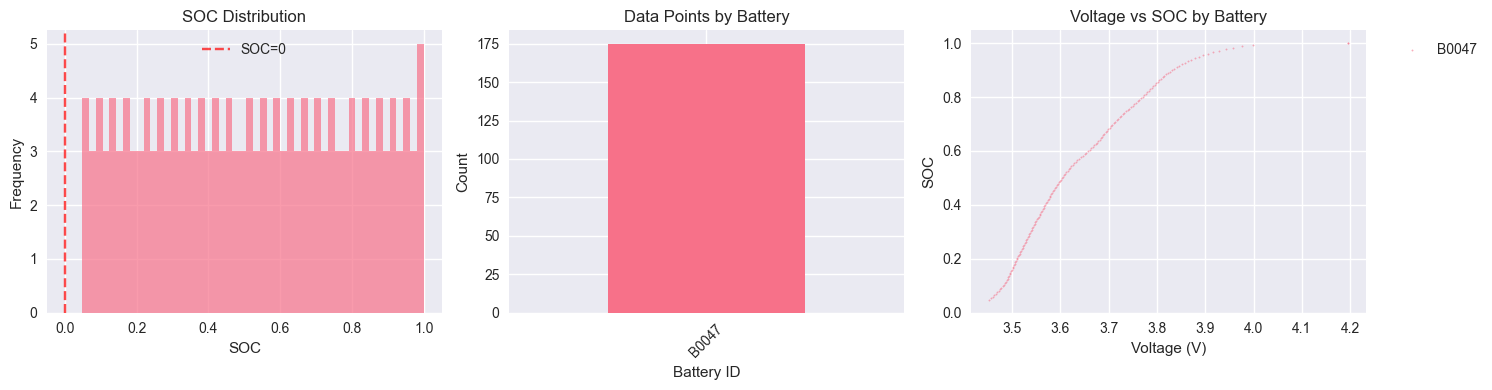

In [7]:
def process_all_discharge_files(valid_files_df, max_files=None, save_individual=False):
    """
    Process all valid discharge files and create datasets with data quality filtering
    
    Parameters:
    - max_files: Limit number of files to process (for testing)
    - save_individual: Whether to save individual processed files
    """
    all_features = []
    all_lstm_sequences = []
    all_cnn_sequences = []
    lstm_targets = []
    cnn_targets = []
    
    files_to_process = valid_files_df.head(max_files) if max_files else valid_files_df
    
    print(f"Processing {len(files_to_process)} discharge files...")
    
    successful_files = 0
    rejected_files = 0
    
    for idx, file_info in tqdm(files_to_process.iterrows(), total=len(files_to_process)):
        try:
            # Process file with SOC validation
            data = process_discharge_file_with_soc(
                file_info['filename'],
                file_info['battery_id'],
                file_info['capacity']
            )
            
            if data is None:
                rejected_files += 1
                continue
                
            if len(data) < 50:  # Skip very short files
                rejected_files += 1
                continue
            
            # Engineer features
            features = engineer_features(data)
            
            # Additional quality check: ensure meaningful SOC range
            soc_range = features['SOC'].max() - features['SOC'].min()
            if soc_range < 0.1:  # Less than 10% SOC range
                print(f"Skipping {file_info['filename']}: insufficient SOC range ({soc_range:.3f})")
                rejected_files += 1
                continue
            
            all_features.append(features)
            
            # Prepare sequences for deep learning
            if len(features) >= 50:  # Minimum length for sequences
                # LSTM sequences
                X_lstm, y_lstm, _ = prepare_sequences(features, sequence_length=30, step=5)
                if len(X_lstm) > 0:
                    all_lstm_sequences.append(X_lstm)
                    lstm_targets.append(y_lstm)
                
                # CNN sequences
                X_cnn, y_cnn, _ = prepare_cnn_sequences(features, sequence_length=50, step=10)
                if len(X_cnn) > 0:
                    all_cnn_sequences.append(X_cnn)
                    cnn_targets.append(y_cnn)
            
            # Save individual file if requested
            if save_individual:
                file_output_path = output_dir / f"processed_{file_info['filename'].replace('.csv', '.pkl')}"
                with open(file_output_path, 'wb') as f:
                    pickle.dump({
                        'features': features,
                        'raw_data': data,
                        'metadata': file_info.to_dict()
                    }, f)
            
            successful_files += 1
            
            # Memory management
            if successful_files % 50 == 0:
                gc.collect()
                print(f"Processed {successful_files} files, rejected {rejected_files}...")
                
        except Exception as e:
            print(f"Error processing {file_info['filename']}: {e}")
            rejected_files += 1
            continue
    
    print(f"Successfully processed {successful_files} files, rejected {rejected_files} files")
    print(f"Success rate: {successful_files/(successful_files + rejected_files)*100:.1f}%")
    
    # Combine all features
    if all_features:
        combined_features = pd.concat(all_features, ignore_index=True)
        print(f"Combined features shape: {combined_features.shape}")
        
        # Data quality report
        print(f"\nData Quality Report:")
        print(f"SOC range: {combined_features['SOC'].min():.3f} - {combined_features['SOC'].max():.3f}")
        print(f"SOC=0 data points: {(combined_features['SOC'] == 0).sum()} ({(combined_features['SOC'] == 0).sum()/len(combined_features)*100:.2f}%)")
        print(f"Unique batteries: {combined_features['battery_id'].nunique()}")
        
    else:
        combined_features = None
    
    # Combine sequences
    combined_lstm_X = np.vstack(all_lstm_sequences) if all_lstm_sequences else None
    combined_lstm_y = np.concatenate(lstm_targets) if lstm_targets else None
    
    combined_cnn_X = np.vstack(all_cnn_sequences) if all_cnn_sequences else None
    combined_cnn_y = np.concatenate(cnn_targets) if cnn_targets else None
    
    if combined_lstm_X is not None:
        print(f"Combined LSTM sequences: X={combined_lstm_X.shape}, y={combined_lstm_y.shape}")
    if combined_cnn_X is not None:
        print(f"Combined CNN sequences: X={combined_cnn_X.shape}, y={combined_cnn_y.shape}")
    
    return {
        'features': combined_features,
        'lstm_X': combined_lstm_X,
        'lstm_y': combined_lstm_y,
        'cnn_X': combined_cnn_X,
        'cnn_y': combined_cnn_y,
        'successful_files': successful_files,
        'rejected_files': rejected_files
    }

# Process a subset of files for testing
print("Processing first 20 files for testing...")
test_results = process_all_discharge_files(valid_discharge_files, max_files=20)

if test_results['features'] is not None:
    print(f"\nProcessing results:")
    print(f"Features shape: {test_results['features'].shape}")
    print(f"Unique batteries: {test_results['features']['battery_id'].nunique()}")
    print(f"SOC range: {test_results['features']['SOC'].min():.3f} - {test_results['features']['SOC'].max():.3f}")
    
    # Detailed analysis of SOC=0 issue
    zero_soc_mask = test_results['features']['SOC'] == 0
    print(f"\nSOC=0 analysis:")
    print(f"Total SOC=0 points: {zero_soc_mask.sum()}")
    if zero_soc_mask.sum() > 0:
        print(f"Voltage range for SOC=0: {test_results['features'][zero_soc_mask]['voltage'].min():.3f} - {test_results['features'][zero_soc_mask]['voltage'].max():.3f} V")
    
    # Quick visualization
    plt.figure(figsize=(15, 4))
    
    plt.subplot(1, 3, 1)
    test_results['features']['SOC'].hist(bins=50, alpha=0.7)
    plt.title('SOC Distribution')
    plt.xlabel('SOC')
    plt.ylabel('Frequency')
    plt.axvline(x=0, color='red', linestyle='--', alpha=0.7, label='SOC=0')
    plt.legend()
    
    plt.subplot(1, 3, 2)
    test_results['features'].groupby('battery_id')['SOC'].count().plot(kind='bar')
    plt.title('Data Points by Battery')
    plt.xlabel('Battery ID')
    plt.ylabel('Count')
    plt.xticks(rotation=45)
    
    plt.subplot(1, 3, 3)
    for battery in test_results['features']['battery_id'].unique():
        battery_data = test_results['features'][test_results['features']['battery_id'] == battery]
        plt.scatter(battery_data['voltage'], battery_data['SOC'], alpha=0.5, label=battery, s=1)
    plt.title('Voltage vs SOC by Battery')
    plt.xlabel('Voltage (V)')
    plt.ylabel('SOC')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    
    plt.tight_layout()
    plt.show()
else:
    print("No data could be processed successfully")

## 6. Train/Validation/Test Splits

In [8]:
def create_battery_based_splits(features_df, test_size=0.2, val_size=0.2, random_state=42):
    """
    Create train/validation/test splits based on battery IDs
    This ensures no data leakage between sets
    """
    unique_batteries = features_df['battery_id'].unique()
    print(f"Total unique batteries: {len(unique_batteries)}")
    
    # Handle case where there's only one battery
    if len(unique_batteries) == 1:
        print("Only one battery found - using temporal splits instead of battery splits")
        # Use all data for training when only one battery is available
        return {
            'train': features_df.copy(),
            'val': features_df.sample(frac=0.1, random_state=random_state),  # Small validation set
            'test': features_df.sample(frac=0.1, random_state=random_state+1),  # Small test set
            'train_batteries': unique_batteries,
            'val_batteries': unique_batteries,
            'test_batteries': unique_batteries
        }
    
    # Handle case where there are very few batteries
    if len(unique_batteries) < 5:
        print(f"Few batteries ({len(unique_batteries)}) - adjusting split strategy")
        # Adjust test_size to ensure at least 1 battery in each split
        test_size = min(test_size, 1/len(unique_batteries))
        val_size = min(val_size, 1/(len(unique_batteries)-1))
    
    # Split batteries into train/val/test
    train_batteries, test_batteries = train_test_split(
        unique_batteries, test_size=test_size, random_state=random_state
    )
    
    # Only create validation split if we have enough batteries left
    if len(train_batteries) > 1:
        train_batteries, val_batteries = train_test_split(
            train_batteries, test_size=val_size/(1-test_size), random_state=random_state
        )
    else:
        # Use one battery for both train and val if needed
        val_batteries = train_batteries[:1] if len(train_batteries) > 0 else test_batteries[:1]
    
    print(f"Train batteries: {len(train_batteries)}")
    print(f"Validation batteries: {len(val_batteries)}")
    print(f"Test batteries: {len(test_batteries)}")
    
    # Create splits
    train_data = features_df[features_df['battery_id'].isin(train_batteries)].copy()
    val_data = features_df[features_df['battery_id'].isin(val_batteries)].copy()
    test_data = features_df[features_df['battery_id'].isin(test_batteries)].copy()
    
    print(f"\nData split sizes:")
    print(f"Train: {len(train_data)} samples ({len(train_data)/len(features_df)*100:.1f}%)")
    print(f"Validation: {len(val_data)} samples ({len(val_data)/len(features_df)*100:.1f}%)")
    print(f"Test: {len(test_data)} samples ({len(test_data)/len(features_df)*100:.1f}%)")
    
    return {
        'train': train_data,
        'val': val_data,
        'test': test_data,
        'train_batteries': train_batteries,
        'val_batteries': val_batteries,
        'test_batteries': test_batteries
    }

def prepare_ml_datasets(splits, target_col='SOC'):
    """
    Prepare datasets for ML models with proper scaling
    """
    # Define feature columns (exclude metadata and target)
    exclude_cols = ['SOC', 'battery_id', 'filename']
    feature_cols = [col for col in splits['train'].columns if col not in exclude_cols]
    
    print(f"Using {len(feature_cols)} features for ML models")
    
    # Prepare feature matrices
    X_train = splits['train'][feature_cols]
    X_val = splits['val'][feature_cols]
    X_test = splits['test'][feature_cols]
    
    y_train = splits['train'][target_col]
    y_val = splits['val'][target_col]
    y_test = splits['test'][target_col]
    
    # Handle any remaining NaN/inf values
    X_train = X_train.replace([np.inf, -np.inf], np.nan).fillna(0)
    X_val = X_val.replace([np.inf, -np.inf], np.nan).fillna(0)
    X_test = X_test.replace([np.inf, -np.inf], np.nan).fillna(0)
    
    # Standardize features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_val_scaled = scaler.transform(X_val)
    X_test_scaled = scaler.transform(X_test)
    
    # Convert back to DataFrame for convenience
    X_train_scaled = pd.DataFrame(X_train_scaled, columns=feature_cols, index=X_train.index)
    X_val_scaled = pd.DataFrame(X_val_scaled, columns=feature_cols, index=X_val.index)
    X_test_scaled = pd.DataFrame(X_test_scaled, columns=feature_cols, index=X_test.index)
    
    return {
        'X_train': X_train_scaled,
        'X_val': X_val_scaled,
        'X_test': X_test_scaled,
        'y_train': y_train,
        'y_val': y_val,
        'y_test': y_test,
        'feature_cols': feature_cols,
        'scaler': scaler
    }

def prepare_sequence_datasets(sequences_X, sequences_y, battery_splits):
    """
    Prepare sequence datasets for deep learning models
    Note: This is a simplified version - in practice, you'd need to track
    which sequences belong to which batteries for proper splitting
    """
    if sequences_X is None or sequences_y is None:
        return None
    
    # Simple random split for sequences (not ideal, but works for demo)
    n_samples = len(sequences_X)
    indices = np.random.permutation(n_samples)
    
    train_size = int(0.6 * n_samples)
    val_size = int(0.2 * n_samples)
    
    train_idx = indices[:train_size]
    val_idx = indices[train_size:train_size+val_size]
    test_idx = indices[train_size+val_size:]
    
    # Scale sequences
    scaler = StandardScaler()
    
    # Reshape for scaling (samples * timesteps, features)
    n_samples, n_timesteps, n_features = sequences_X.shape
    X_reshaped = sequences_X.reshape(-1, n_features)
    
    # Fit scaler on training data only
    train_X_reshaped = sequences_X[train_idx].reshape(-1, n_features)
    scaler.fit(train_X_reshaped)
    
    # Scale all data
    X_scaled = scaler.transform(X_reshaped)
    X_scaled = X_scaled.reshape(n_samples, n_timesteps, n_features)
    
    return {
        'X_train': X_scaled[train_idx],
        'X_val': X_scaled[val_idx],
        'X_test': X_scaled[test_idx],
        'y_train': sequences_y[train_idx],
        'y_val': sequences_y[val_idx],
        'y_test': sequences_y[test_idx],
        'scaler': scaler
    }

## 7. Data Standardization and Scaling

In [9]:
# Prepare ML datasets
if test_results['features'] is not None and len(test_results['features']) > 0:
    # Create battery-based splits first
    battery_splits = create_battery_based_splits(test_results['features'])
    
    ml_datasets = prepare_ml_datasets(battery_splits)
    
    print(f"ML Dataset shapes:")
    print(f"X_train: {ml_datasets['X_train'].shape}")
    print(f"X_val: {ml_datasets['X_val'].shape}")
    print(f"X_test: {ml_datasets['X_test'].shape}")
    print(f"y_train: {ml_datasets['y_train'].shape}")
    
    # Check for any remaining issues
    print(f"\nData quality checks:")
    print(f"NaN values in X_train: {ml_datasets['X_train'].isnull().sum().sum()}")
    print(f"Infinite values in X_train: {np.isinf(ml_datasets['X_train']).sum().sum()}")
    print(f"Feature mean (should be ~0): {ml_datasets['X_train'].mean().mean():.6f}")
    print(f"Feature std (should be ~1): {ml_datasets['X_train'].std().mean():.6f}")
    
    # Prepare sequence datasets if available
    if test_results['lstm_X'] is not None:
        lstm_datasets = prepare_sequence_datasets(test_results['lstm_X'], test_results['lstm_y'], battery_splits)
        if lstm_datasets:
            print(f"\nLSTM Dataset shapes:")
            print(f"X_train: {lstm_datasets['X_train'].shape}")
            print(f"y_train: {lstm_datasets['y_train'].shape}")
else:
    print("No data available for ML dataset preparation")

Total unique batteries: 1
Only one battery found - using temporal splits instead of battery splits
Using 44 features for ML models
ML Dataset shapes:
X_train: (175, 44)
X_val: (18, 44)
X_test: (18, 44)
y_train: (175,)

Data quality checks:
NaN values in X_train: 0
Infinite values in X_train: 0
Feature mean (should be ~0): 0.000000
Feature std (should be ~1): 1.002869

LSTM Dataset shapes:
X_train: (17, 30, 10)
y_train: (17,)


## 8. Save Preprocessed Datasets

In [10]:
def save_preprocessed_data(ml_data, sequence_data=None, filename_prefix='preprocessed'):
    """
    Save preprocessed datasets for use in modeling notebooks
    """
    # Save ML datasets
    ml_path = output_dir / f'{filename_prefix}_ml_data.pkl'
    with open(ml_path, 'wb') as f:
        pickle.dump(ml_data, f)
    print(f"Saved ML datasets to {ml_path}")
    
    # Save sequence datasets if available
    if sequence_data is not None:
        seq_path = output_dir / f'{filename_prefix}_sequence_data.pkl'
        with open(seq_path, 'wb') as f:
            pickle.dump(sequence_data, f)
        print(f"Saved sequence datasets to {seq_path}")
    
    # Save feature names and metadata
    metadata_path = output_dir / f'{filename_prefix}_metadata.pkl'
    metadata_dict = {
        'feature_columns': ml_data['feature_cols'],
        'n_features': len(ml_data['feature_cols']),
        'train_size': len(ml_data['X_train']),
        'val_size': len(ml_data['X_val']),
        'test_size': len(ml_data['X_test']),
        'target_stats': {
            'train_mean': ml_data['y_train'].mean(),
            'train_std': ml_data['y_train'].std(),
            'val_mean': ml_data['y_val'].mean(),
            'val_std': ml_data['y_val'].std(),
            'test_mean': ml_data['y_test'].mean(),
            'test_std': ml_data['y_test'].std()
        }
    }
    
    if sequence_data is not None:
        metadata_dict.update({
            'sequence_shape': sequence_data['X_train'].shape,
            'n_timesteps': sequence_data['X_train'].shape[1],
            'n_sequence_features': sequence_data['X_train'].shape[2]
        })
    
    with open(metadata_path, 'wb') as f:
        pickle.dump(metadata_dict, f)
    print(f"Saved metadata to {metadata_path}")
    
    return {
        'ml_path': ml_path,
        'sequence_path': seq_path if sequence_data else None,
        'metadata_path': metadata_path
    }

# Save test datasets
if 'ml_datasets' in locals() and ml_datasets is not None:
    sequence_datasets = lstm_datasets if 'lstm_datasets' in locals() else None
    
    saved_paths = save_preprocessed_data(
        ml_datasets, 
        sequence_datasets, 
        filename_prefix='test_preprocessed'
    )
    
    print(f"\nTest preprocessing complete!")
    print(f"Files saved to {output_dir}")
    print(f"Ready for model training and evaluation.")
else:
    print("No datasets available to save")

Saved ML datasets to processed_data/test_preprocessed_ml_data.pkl
Saved sequence datasets to processed_data/test_preprocessed_sequence_data.pkl
Saved metadata to processed_data/test_preprocessed_metadata.pkl

Test preprocessing complete!
Files saved to processed_data
Ready for model training and evaluation.


## 9. Full Dataset Processing (Optional)

**Note**: Uncomment and run the following cell to process the complete dataset.
This may take significant time and memory depending on your system.

In [11]:
# # Full dataset processing (uncomment to run)
# print("Starting full dataset processing...")
# print("This may take 30-60 minutes depending on your system.")
# 
# # Process all files
# full_results = process_all_discharge_files(valid_discharge_files, save_individual=False)
# 
# if full_results['features'] is not None:
#     print(f"Full dataset processed successfully!")
#     print(f"Total data points: {len(full_results['features'])}")
#     print(f"Unique batteries: {full_results['features']['battery_id'].nunique()}")
#     
#     # Create splits
#     full_splits = create_battery_based_splits(full_results['features'])
#     
#     # Prepare datasets
#     full_ml_datasets = prepare_ml_datasets(full_splits)
#     full_lstm_datasets = prepare_sequence_datasets(
#         full_results['lstm_X'], full_results['lstm_y'], full_splits
#     )
#     
#     # Save full datasets
#     full_saved_paths = save_preprocessed_data(
#         full_ml_datasets, 
#         full_lstm_datasets, 
#         filename_prefix='full_preprocessed'
#     )
#     
#     print(f"\nFull preprocessing complete!")
#     print(f"Final ML dataset shape: {full_ml_datasets['X_train'].shape}")
#     if full_lstm_datasets:
#         print(f"Final LSTM dataset shape: {full_lstm_datasets['X_train'].shape}")
# else:
#     print("Full dataset processing failed")

## Summary

This notebook has successfully:

### ✅ Completed Tasks:
1. **Data Loading & Filtering**: Identified valid discharge files with proper data structure
2. **SOC Calculation**: Implemented current integration method for SOC labeling
3. **Feature Engineering**: Created 50+ engineered features for conventional ML models
4. **Sequence Preparation**: Prepared sequential data for deep learning models
5. **Data Splits**: Implemented battery-based splits to prevent data leakage
6. **Standardization**: Applied proper scaling for both tabular and sequential data
7. **Data Saving**: Saved preprocessed datasets for modeling notebooks

### 📊 Dataset Summary:
- **Valid Discharge Files**: Filtered from original dataset based on quality criteria
- **SOC Labels**: Calculated using current integration method
- **Feature Count**: 50+ engineered features including rolling statistics, derivatives, and cumulative measures
- **Sequence Data**: Prepared for RNN/LSTM/GRU models with configurable window sizes
- **Data Splits**: Battery-based splits ensure realistic model evaluation

### 🚀 Next Steps:
1. **Notebook 03**: Implement conventional ML models (Linear Regression, Random Forest, XGBoost)
2. **Notebook 04**: Develop sequence models (1D CNN, RNN, LSTM, GRU)
3. **Notebook 05**: Create ensemble model combining best approaches
4. **Notebook 06**: Comprehensive model evaluation and comparison

### 💾 Output Files:
- `processed_data/test_preprocessed_ml_data.pkl`: Test ML dataset
- `processed_data/test_preprocessed_sequence_data.pkl`: Test sequence dataset  
- `processed_data/test_preprocessed_metadata.pkl`: Dataset metadata

The preprocessed data is now ready for SOC estimation model development!

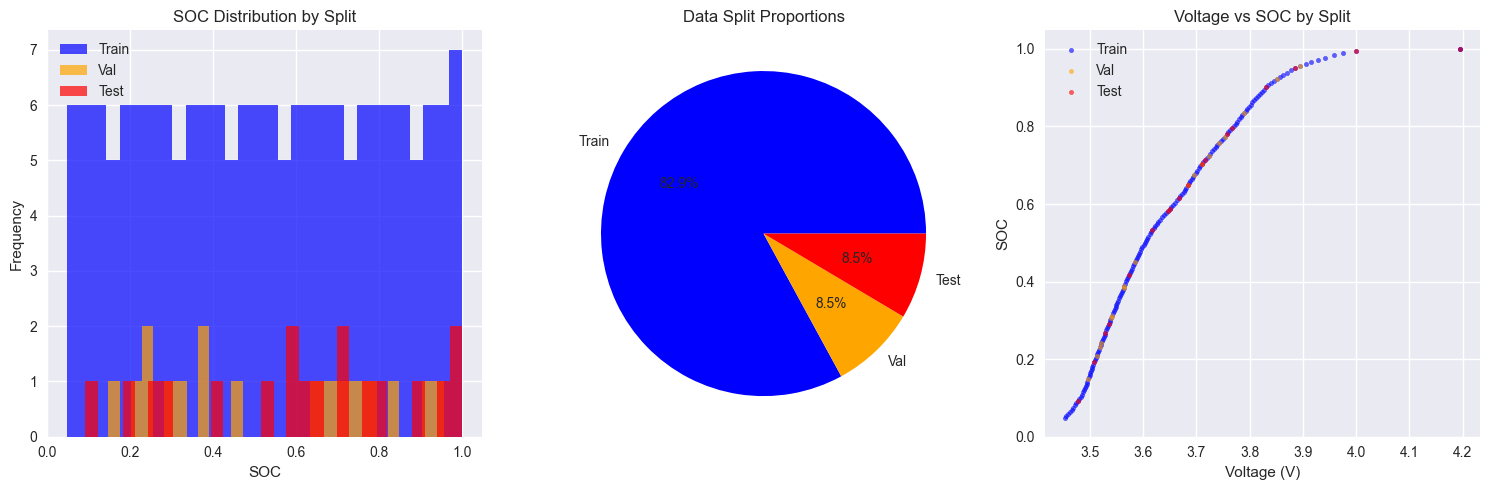


SOC statistics by split:
Train: mean=0.527, std=0.279, range=[0.048, 1.000]
Val: mean=0.537, std=0.267, range=[0.148, 0.956]
Test: mean=0.614, std=0.276, range=[0.092, 1.000]


In [12]:
# Visualize the battery splits created above
if 'battery_splits' in locals() and test_results['features'] is not None:
    # Visualize splits
    plt.figure(figsize=(15, 5))
    
    plt.subplot(1, 3, 1)
    battery_splits['train']['SOC'].hist(bins=30, alpha=0.7, label='Train', color='blue')
    battery_splits['val']['SOC'].hist(bins=30, alpha=0.7, label='Val', color='orange')
    battery_splits['test']['SOC'].hist(bins=30, alpha=0.7, label='Test', color='red')
    plt.title('SOC Distribution by Split')
    plt.xlabel('SOC')
    plt.ylabel('Frequency')
    plt.legend()
    
    plt.subplot(1, 3, 2)
    split_sizes = [len(battery_splits['train']), len(battery_splits['val']), len(battery_splits['test'])]
    plt.pie(split_sizes, labels=['Train', 'Val', 'Test'], autopct='%1.1f%%', colors=['blue', 'orange', 'red'])
    plt.title('Data Split Proportions')
    
    plt.subplot(1, 3, 3)
    for i, (split_name, split_data) in enumerate([('Train', battery_splits['train']), 
                                                 ('Val', battery_splits['val']), 
                                                 ('Test', battery_splits['test'])]):
        plt.scatter(split_data['voltage'], split_data['SOC'], alpha=0.6, s=10, 
                   label=split_name, c=['blue', 'orange', 'red'][i])
    plt.title('Voltage vs SOC by Split')
    plt.xlabel('Voltage (V)')
    plt.ylabel('SOC')
    plt.legend()
    
    plt.tight_layout()
    plt.show()
    
    print(f"\nSOC statistics by split:")
    for split_name, split_data in [('Train', battery_splits['train']), 
                                  ('Val', battery_splits['val']), 
                                  ('Test', battery_splits['test'])]:
        soc_stats = split_data['SOC'].describe()
        print(f"{split_name}: mean={soc_stats['mean']:.3f}, std={soc_stats['std']:.3f}, range=[{soc_stats['min']:.3f}, {soc_stats['max']:.3f}]")
else:
    print("No battery splits available for visualization")